# k-means

The $k$-means algorithm is one of the best-known and most widely used clustering methods, although it has some serious limitations and drawbacks. 

Given a sample matrix $\bfX$ with $n$ rows $\bfx_i$, the algorithm divides the sample points into disjoint sets $C_1,\ldots,C_k$. Cluster $j$ has a **centroid** $\bfmu_j$, which is the mean of the points in $C_j$. Define the **inertia** of $C_j$ as 

$$
I_j = \sum_{\bfx\in C_j} \norm{ \bfx - \bfmu_j }^2.
$$

The goal of the algorithm is to choose the clusters in order to minimize the total inertia,

$$
I = \sum_{j=1}^k I_j.
$$

This is a hard problem to solve exactly (technically, NP-hard even for $k=2$), so the algorithm uses a heuristic method to look for the minimum. 

## Lloyd's algorithm

The standard method is known as **Lloyd's algorithm**. Starting with values for the $k$ centroids, there is an iteration consisting of two steps:

* **Assignment** Each sample point is assigned to the cluster whose centroid is the nearest. (Ties are broken randomly.)
* **Update** Recalculate the centroids based on the cluster assignments:

$$
\bfmu_j^+ = \frac{1}{|C_j|} \sum_{\bfx\in C_j} \bfx.
$$

The algorithm stops when the assignment step does not change any of the clusters. In practice, this almost always happens quickly. 

## Practical issues

* **Initialization** The performance of $k$-means depends a great deal on the initial set of centroids. Traditionally, the centroids were chosen as random members of the sample set, but better/more reliable heuristics, such as *$k$-means++*, have since become more dominant. 
* **\bfmultiple runs** All the initialization methods include an element of randomness, and since the Lloyd algorithm usually converges quickly, it is usually run with \bfmultiple instances of the initialization, and the run with the lowest inertia is kept.
* **Selection of $k$** The algorithm treats $k$ as a hyperparameter. Occam's Razor dictates preferring smaller values to large ones. There are many suggestions on how to find the choice that gives the most "bang for the buck."
* **Distance metric** The Lloyd algorithm often fails to converge for norms other than the 2-norm, and \bfmust be modified if another norm is preferred.
* **Shape effects** Because of the dependence on the 2-norm, the inertia criterion disfavors long, skinny clusters (i.e., anisotropic), and clusters of unequal spread (variance). Basically, it wants to find spherical blobs of roughly equal size and membership.

## Toy example

Let's regenerate the blobs from the previous section.

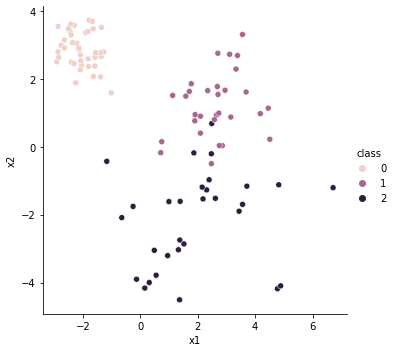

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_blobs
X,y = make_blobs(
    n_samples=[40,30,30],
    centers=[[-2,3],[3,1.5],[2,-2]],
    cluster_std=[0.5,0.9,1.5],
    random_state = 19716
    )
blobs = pd.DataFrame({"x1":X[:,0],"x2":X[:,1],"class":y})
sns.relplot(data=blobs,x="x1",y="x2",hue="class");

Now we try $k$-means with $k=3$.

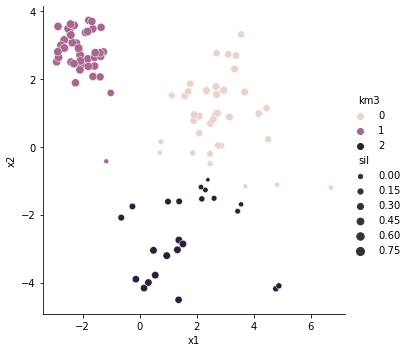

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

km = KMeans(n_clusters=3)
km.fit(X)

blobs["km3"] = km.predict(X)
blobs["sil"] = silhouette_samples(X,blobs["km3"])
sns.relplot(data=blobs,x="x1",y="x2",hue="km3",size=blobs["sil"]);

Intuitively, this seems like a better clustering than the original. The silhouette scores show a modest reduction for the better clusters, but major improvement for the problematic one.

In [3]:
blobs.groupby("km3")["sil"].mean()

km3
0    0.493170
1    0.793501
2    0.401121
Name: sil, dtype: float64

What happens when we ask for just $k=2$ clusters?

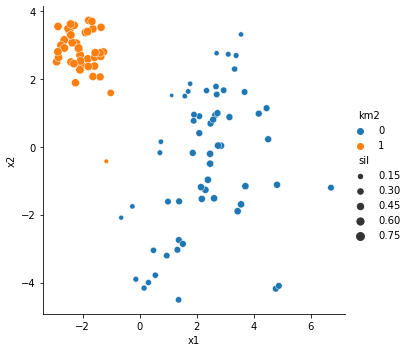

In [4]:
km = KMeans(n_clusters=2)
km.fit(X)

blobs["km2"] = km.predict(X)
blobs["sil"] = silhouette_samples(X,blobs["km2"])
sns.relplot(data=blobs,x="x1",y="x2",hue="km2",size=blobs["sil"]);

This result too is arguably superior to the reference clustering we created.

In [5]:
blobs.groupby("km2")["sil"].mean()

km2
0    0.456869
1    0.813098
Name: sil, dtype: float64

The outlier points in the generated blobs are perhaps best seen as noisy examples, at least for the purposes of clustering. 

## #notalldatasets

It's worth keeping in mind that clustering is an artificial classification that may not reflect reality.
For example, we can load a famous data set generated from handwriting recognition for the digits 0 through 9. It's natural to try a $k$-means clustering with $k=10$.

In [6]:
from sklearn import datasets
digits = datasets.load_digits(as_frame=True)["frame"]
X = digits.drop("target",axis="columns")
y = digits["target"]
km = KMeans(n_clusters=10)
km.fit(X)
digits["km"] = km.predict(X)

The Rand index suggests that these clusters aren't doing a great job at identifying digits.

In [7]:
from sklearn.metrics import adjusted_rand_score
print("ARI:",adjusted_rand_score(y,digits["km"]))

ARI: 0.6658996801930657


We might be tempted to push harder for a better clustering result. However, it's worth visualizing the silhouette scores for the ground-truth clustering:

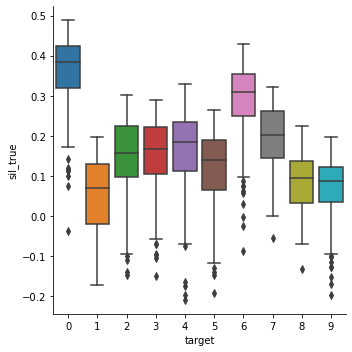

In [8]:
digits["sil_true"] = silhouette_samples(X,y)
sns.catplot(data=digits,x="target",y="sil_true",kind="box");

There are some low-quality clusters there, most notably classes 1, 8, and 9. In fact, the silhouette scores in our clustering are similar or better already:

In [9]:
digits["sil_kmeans"] = silhouette_samples(X,digits["km"])
digits.groupby("target")[["sil_true","sil_kmeans"]].median()

,sil_true,sil_kmeans
target,,
0,0.383051,0.370894
1,0.069325,0.189545
2,0.156625,0.157407
3,0.166186,0.145116
4,0.184106,0.180891
5,0.139994,0.144980
6,0.309357,0.306704
7,0.202178,0.191620
8,0.094333,0.081606


It seems unlikely, then, that the recognition of digits can be greatly improved by finding a better clustering, at least in the sense of the 2-norm. Instead, we would be better off exploring different norms, engineering new features, or trying another classification method altogether.